<img style="float: right; width: 320px; display: inline" src="https://upload.wikimedia.org/wikipedia/commons/thumb/0/06/LMU_Muenchen_Logo.svg/2000px-LMU_Muenchen_Logo.svg.png">
<p>  
    <font face='Helvetica' size='5.6'><b>Using a Recurrent Neural Network Using Keras</b></font><br><br> 
    <font face='Helvetica' size='4.6'>Ludwig-Maximilians-Universität München</font>
</p>

---

The attractive nature of RNNs comes froms our desire to work with data that has some form of statistical dependency on previous and future outputs. This can take the form of text, such as learning how words in a sentence should flow. It can take the form of timeseries data, such as seismograms, just to name a few. Recall that recurrent neural networks processes sequences by iterating through the sequence of elements and maintaining a state containing information relative to what it has seen so far. [Chollet, F. (2017)]  

With our basic understanding of RNNs, it's time to dive into a small examples using real timeseries data.   

Let's remind ourselves what the general machine learning workflow is so that we don't get lost:

<b>Frame the Problem</b> --> <b>Get the Data</b> --> <b>Explore the Data</b> --> <b>Prepare the Data</b> --> <b>Short-List Promising Models</b> --> <b>Fine-Tune the System</b>

We won't have time to go through each of these steps in detail, but I encourage you to read Chapter 2 from Géron's book [see Suggested Reading below]. 

In [1]:
# Run this first
import os
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop

Using TensorFlow backend.


<h2>Frame the Problem</h2>

We want to know if it is possible to predict the temperature in the future? For a given day, we want to look back some days (i.e. time steps) and use said information to predict the weather in the future.  We'll use the following variables to contrain what we mean by 'past' and 'future':  

<span style="font-family:Courier; font-size:1.1em;">look back</span> - number of timesteps to look back from   
<span style="font-family:Courier; font-size:1.1em;">delay</span>  - number of timesteps in the future   
<span style="font-family:Courier; font-size:1.1em;">steps</span>  -  our sample rate  

In our case that we will set:<br><span style="font-family:Courier; font-size:1.1em;">look back</span> = 1440 (1 day consists of 1440 minutes),<br> <span style="font-family:Courier; font-size:1.1em;">step</span> = 6 (one data point per hour), and<br> <span style="font-family:Courier; font-size:1.1em;">delay</span> = 1440 (one day in the future).

In [2]:
# How many timesteps back the input data should go.
# Note: 1 day is 1440 minutes
lookback = 1440

# The period, in timesteps, at which you sample data. Set to 6 in
# order to draw one data point every hour.
step = 6

# How many timesteps in the future the target should be.
delay = 1440

<h2>Get the Data</h2>  

Our data set is a timeseries from the Weather Station at the Max Planck Institute for [Biogeochemistry in Jena, Germany](https://www.bgc-jena.mpg.de/wetter/).  Lucky for us, this is already in a format we can quickly and easily work with. We just need to read it in, store it in a workable format, and do some very basic data processing.  

Download the data and store it in your working directory. Once you have done that, execute this block:

In [3]:
data_dir = './'
fname = os.path.join(data_dir, 'jena_climate_2009_2016.csv')

f = open(fname)
data = f.read()
f.close()

Since we are working with a .csv file we first need to read it in, and then beat it into something we can work with. Depending on how large your data set is (both row and column-wise) you might want to invest learning using [Pandas](https://pandas.pydata.org/). It is a library that allows for easy data manipulation and works great for .csv, .xlsx, and .txt sort of data file types.  

We only have a few thousand samples (420551, to be exact), so we will just use some build-in Python functions:  

In [4]:
lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]

print("Our header information: ",'\n')
print(header)

Our header information:  

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']


Note that we seperated the header titles and stored them in the "header" variable. We also made sure to remove the first column in our floats which contained the "Date Time" values. [Line #3]  

Now that we have read our data in, let's parse it and store it into a Numpy array so we can easily access the float values later:

<h3>Parse the Data into a Numpy Array</h3>

In [5]:
float_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    float_data[i, :] = values

I like to do sanity checks along the way, so let's make sure our dimensions make sense:  

In [6]:
print(float_data.shape)

(420551, 14)


We have 420551 time steps (done every 10 minutes), with 14 columns/features. I.e. we created a 2D tensor with dimensions: (# of samples, features).  

Great. So far so good.  

<h2>Explore the Data</h2>

It's always a good idea to get a sense of what our data looks like. <b>Data exploration</b> is a necessary step to get a broad sense of what kind of data you are working with and to get an overall 'feel' for the data. Depending on the data type, you might want to make histograms or scatter plots for each numerical attribute.  You could also compute some basic statistical attributes of your data set such as the mean, standard deviations, minimum and maximum values, and percentiles. (You can take advantage of <a href="https://pandas.pydata.org/">Pandas</a>' built-in function for quick results).  

Let's do a VERY mild peek at our data. Specifically, let's plot the temperature and see how it behaves over time:  

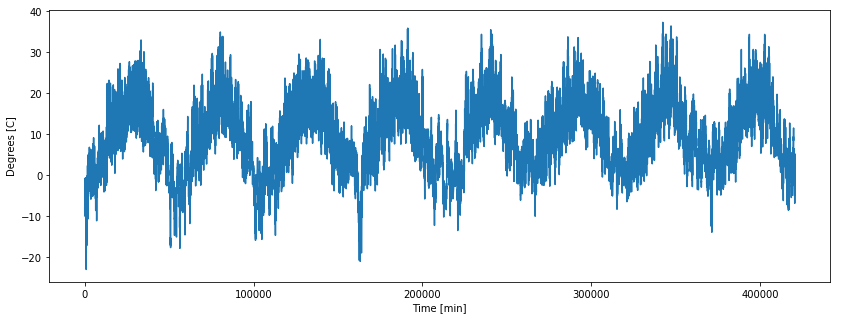

In [7]:
temp = float_data[:, 1]  # temperature (in degrees Celsius)

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14,5))
ax.plot(range(len(temp)), temp)
ax.set_ylabel('Degrees [C]')
ax.set_xlabel('Time [min]')

plt.show()

As one might expect (or hope to expect), we see a periodic temperature pattern over the years.  

<h2>Prepare the Data for Training</h2>

Depending on what your data set is, you might consider using transformation Pipelines for preprocessing your data. 
In our case, we want to take care of the fact our data has different scales. Neural networks don't perform well if their scales are dramatically different. No problem, we'll just normalize our timeseries.

<b>Note:</b> We only do this to our training data (our first 200000 time steps). So only compute and modify these sampels:

In [8]:
mean = float_data[:200000].mean(axis=0)
float_data -= mean
std = float_data[:200000].std(axis=0)
float_data /= std

<h2>Split Data into Training, Validation, and Testing</h2>

Always split your data set into a <b>trainig</b>, <b>validation</b>, and a <b>test</b> set.  As a rule of thumb: you'll want to split it such that you leave 20% of your data for testing and keep the rest as your training and validation set.  The bottom snippet of code might look confusing at first, but all it is is a Python Generator for creating the above mentioned data sets.      

In [9]:
# Generator yields a tuple (samples, targets), where samples is one batch 
# of input data and targets is the corresponding array of
# target temperatures.
def generator(data, lookback, delay, min_index, max_index,\
              shuffle=False, batch_size=128, step=6):
    """
    Parameters
    ----------
    data: array, dtype = floats or integers
        array containing our data 
    
    lookback: integer
        number of timesteps to take backward from current index
    
    delay: integer
        number of timesteps to take forward from current index
    
    min_index: integer
        index value used to set lower bound in data array
        e.g. array_test[min_index:]
    
    max_index: integer
        index value used to cap data array
        e.g. array_test[:max_index]
    
    shuffle: boolean
        used to determine whether or not to shuffle data or
        keep in given order
    
    batch_size: integer
        how many sequences to give per epoch
        
    step: integer
        The period, in timesteps, we sample data with
    
    Returns:
    -------
    samples: array, dtype = float or int
        a single batch of input data 
    
    targets: array, dtype = float, int, or str
        a single array of target values (in this case temperature)
    """
    
    if max_index is None:
        max_index = len(data) - delay - 1
    i = min_index + lookback
    while 1:
        if shuffle:
            rows = np.random.randint(min_index + lookback, max_index, size=batch_size)
        else:
            if i + batch_size >= max_index:
                i = min_index + lookback
            rows = np.arange(i, min(i + batch_size, max_index))
            i += len(rows)
        samples = np.zeros((len(rows),lookback // step,data.shape[-1]))
        targets = np.zeros((len(rows),))
        for j, row in enumerate(rows):
            # range(start, end, steps)
            # First value you start from a random time spot, then go back one day.
            # i.e. start: random_time - day, end on random_time, take steps of one hour
            # Want one sample every hour) --> 1440 minutes / 60 minutes = 240 timesteps
            indices = range(rows[j] - lookback, rows[j], step)
            samples[j] = data[indices]
            samples[j] = data[indices]
        yield samples, targets

Going back to our problem, we said we wanted to use data going back a certain amount of time (data points in our timeseries) to predict the weather in the future (defined by the variable <span style="font-family:Courier; font-size:1.1em;">delay</span>). Let's create the data sets we need to feed our recurrent neural network:  

In [10]:
# How many timesteps back the input data should go.
# Note: 1 day is 1440 minutes
lookback = 1440

# The period, in timesteps, at which you sample data. Set to 6 in
# order to draw one data point every hour.
step = 6

# How many timesteps in the future the target should be.
delay = 144

# The number of samples per batch.
batch_size = 128

# Generate data
train_gen = generator(float_data, lookback=lookback, delay=delay,\
                      min_index=0, max_index=200000, shuffle=True,\
                      step=step, batch_size=batch_size)

val_gen = generator(float_data, lookback=lookback, delay=delay,\
                    min_index=200001, max_index=300000, step=step,\
                    batch_size=batch_size)

test_gen = generator(float_data, lookback=lookback, delay=delay,\
                     min_index=300001, max_index=None, step=step,\
                     batch_size=batch_size)

# How many steps to draw from val_gen in order to see the entire validation set.
val_steps = (300000 - 200001 - lookback)

# How many steps to draw from test_gen in order to see the entire test set.
test_steps = (len(float_data) - 300001 - lookback)

<h2>Establishing a Common Sense Non Machine Learning Baseline</h2>

Before running this model you want to establish a baseline. Baslines are useful for a couple of reasons: first, it gives you something to compare the performance of your machine learning algorithm with. If your computationally heavy, machine learning algorithm does not perform better than a simple MAE, well...then there's not really a point to use a machine learning algorithm; The second reason for creating a baseline: they serve as a sanity check.    

Since we are curious about predicting the temperature in the future, a common sense non machine learning baseline could involve using temperature from the last 24 hours to say something about right now.  

One of doing this could be using an MAE. Here is a code snippet example:

And the associated code snippet for the entire loop:  

If you compute the standard deviation of the temperature and run the code snippet above, you'll be get an MAE = 0.29  . This number obviously doesn't make any intuitive sense because our data was normalized to be centered at 0 and have a standard deviation of 1.  Translating this into something more understandable, we have an absolute error of:  

<center>0.29 * <span style="font-family:Courier; font-size:1.1em;">temperature_std</span> = 2.57°C</center>  

Which is not terrible, but it's not great. We hope that our machine learning approach will better. Let's find out.  

<h2>A Basic Machine Learning Approach</h2>

<br>
<center><b>BEFORE RUNNING FUTURE CELLS, READ THIS:</b></center>  

My good ol' '12 Macbook Pro had some trouble running the following machine learning algorithms. In other words, executing the next cells did not ....umm...run in a timely fashion (this is not too shocking since we are working with deep neural networks).  

I would suggest trying to execute the next block but then interrupting the kernal once you get a flavor of how long it'll take to run.

Because of this shortcoming, I've provided screen shots for the remaining part of the notebook of what will show up if you were to run this:  

In [ ]:
model = Sequential()
# input shape: (240, 14)
model.add(layers.Flatten(input_shape=(lookback // step, float_data.shape[-1])))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=100,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

<img src="./img/prog_bar_basicML.png"  >

<h2>Interpreting the Results of a Basic Machine Learning Algorithm</h2>  

Let's plot the loss curves for both the training and validation data sets:  

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<img src="./img/newfirst_ml_approach.png" width="410" >

What do we see? On the x-axis we one again have epochs and the y-axis we see the output of our loss function, the mean absolute error. Looking at the training loss we note that with increasing epoch our loss is going down. i.e. the function we are trying to minimize is actually being minimized.

But, we can't celebrate just yet. Arguably more important is understanding our validation loss. We would hope that it too would have smaller loss values with each iteration. Instead, we see that our validation loss is increasing after iteration 5.
  
<h3>A Little Blurb on the Hypothesis Space</h3>

Interesing enough, our 'common sense' approach earlier gave us a MAE of 0.29. Which, comparing to our results, is actually better. Why is this? More specifically, why didn't we find the same hypothesis used for the common sense approach?  

Remember that the overall objective of a machine learning algorithm is to find the mapping function/hypothesis between an independent variable X and a dependent variable y such that it best minimizes the cost function. The hypothesis space, where our mapping function lives, of our machine learning network is the space of all possible 2-layer networks with the configuration that we defined. So, it may be that the space we just defined with our machine learning algorithm doesn't actually have the hypothesis we originally found.  


Let's now move on to the main purpose of this notebook, using a recurrent neural netork.

---

<h2>Building a RNN with Keras</h2>

The simplest RNN we can use with Keras is literally called  

<center><span style="font-family:Courier; font-size:1.1em;">model.add(SimpleRNN( ))</span>  </center>  

For example:  

In [1]:
from keras.models import Sequential
from keras import layers 
from keras.layers import Embedding, Dense, SimpleRNN

model = Sequential()
model.add(SimpleRNN(10, input_shape=(3, 1)))
model.add(Dense(1))

Using TensorFlow backend.


Let's look at this line by line:  

<b>Line 5:</b> Defined our model architect using a <span style="font-family:Courier; font-size:1.1em;">Sequential</span> class. 

<b>Line 6:</b> Added our RNN layer (which also serves as our input layer).

<b>Line 7:</b> Added a fully connected (i.e. Dense) layer as our output layer. 

The <span style="font-family:Courier; font-size:1.1em;">model.summary()</span> function is a convenient way of checking how our deep neural network textually looks like. It provides key information of our architecture such as:  

the <b>layer type</b> and the order of the layers from input (first row) to output (bottom row before the '=');  
the <b>shape of the tensor</b> for each output (and thus, what is going into the next layer);  
and the <b>number of weights</b> (here labeled 'parameters') per layer along with a summary of the total number of weights.  

For example:  

In [2]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
simple_rnn_1 (SimpleRNN)     (None, 10)                120       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 11        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


What do we see? The first line is our header  

<center>[ <span style="font-family:Courier; font-size:1.1em;">Layer(type)</span>, <span style="font-family:Courier; font-size:1.1em;"> Output Shape,</span>, and <span style="font-family:Courier; font-size:1.1em;"> Param # </span>]</center>   
Where <span style="font-family:Courier; font-size:1.1em;">Output Shape</span> is the shape of the tensor that is leaving our first layer (<span style="font-family:Courier; font-size:1.1em;">SimpleRNN</span>) and going into the next layer <span style="font-family:Courier; font-size:1.1em;">Dense</span> (i.e. a fully connected layer).     

In the next line We see that we have an output shape of (None, 10) and 120 Parameters:<br>  

<center><span style="font-family:Courier; font-size:1.1em;">simple_rnn_1 (SimpleRNN) (None, 10) 120 </span>  </center>  

What does this mean? When we wrote line 6:  
<center><span style="font-family:Courier; font-size:1.1em;">SimpleRNN(10, input_shape=(3, 1))</span></center>

We specified that we had 10 weights (parameters) and input shape of (3,1). The 3 here means we have 3 sequences(e.g. three timeseries points) we want to input and 1 featuere (e.g. Temperature).  

The formula for the number of parameters/weights:  
<br><center><span style="font-family:Courier; font-size:1.1em;">Parameters</span> = num_weights x num_weights + num_features x num_weights + biases</center>

<center> = $10 * 10 + 1 * 10 + 10 = 120$</center>  

<b>Note: Full explaination of the parameters below</b>  

Finally, we have our output layer. In this example we defined it as a <span style="font-family:Courier; font-size:1.1em;">Dense</span> layer:   
<br>
<center><span style="font-family:Courier; font-size:1.1em;">Dense(1)</span>  </center>  

So this last <span style="font-family:Courier; font-size:1.1em;">Dense</span> layer takes its input (<span style="font-family:Courier; font-size:1.1em;">10</span> (the output of the previous layer) and adds the bias to give us <span style="font-family:Courier; font-size:1.1em;">11</span> parameters/weights. Since we defined the dense layer as: <span style="font-family:Courier; font-size:1.1em;">Dense(1)</span> we are telling our neural network that we want a single output.

---

<h2>A Recurrent Neural Network Baseline</h2>

Just like in our previous notebook we'll create our deep neural network by first defining our model architecture with Keras' <span style="font-family:Courier; font-size:1.1em;">Sequential class</span>. We'll make a key change in that instead of using a <span style="font-family:Courier; font-size:1.1em;">SimpleRNN</span> we'll use a <span style="font-family:Courier; font-size:1.1em;">GRU</span> layer. I won't go into the details here (if you are curious to learn more, I would suggest reading this [blog](https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be) post) of what GRUs are for brevity. But basically, GRUs are a variation of our Recurrent Neural Network except that it handles the <b>vanishing gradient problem</b>. The link to the paper describing this by Cho, et al. can be found below in the Suggested Reading section.  

In [ ]:
model = Sequential()
model.add(layers.GRU(32, input_shape=(None, float_data.shape[-1])))
# Note that our output layer is defined to have a single value(i.e. a temperature)
model.add(layers.Dense(1))

model.compile(optimizer=RMSprop(), loss='mae')
history = model.fit_generator(train_gen,
                              steps_per_epoch=500,
                              epochs=20,
                              validation_data=val_gen,
                              validation_steps=val_steps)

<img src="./img/epochs_run.png">

What does the above show us? For each epoch Keras is printing out:  

1) How long it took (e.g. 10 seconds in this case)  
2) The loss from the training and validation data sets.  

The second point here is worth spending some time thinking about. Remember that the overall objective is for us to create an algorithm which learns from the data we give it. i.e. we want our algorithm to generalize to data sets it has never seen before.  We should expect, therefore, that the training loss decreases for every epoch. Does this happen in our case? Plotting the training and validation loss will help us understand a litte more of how well our deep neural network did:  

<h2>Interpreting the Results From the RNN</h2>

In [ ]:
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(loss))

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

<img src="./img/traning_val_plot.png" style="width: 500px;">

What do we see? On the x-axis we once again have epochs and the y-axis we see the output of our loss function, the mean absolute error (which we defined when we compiled our RNN in code line 6) .  Looking at the training loss we note that with increasing epoch our loss is going down. i.e. the function we are trying to minimize is actually being minimized just like in our basic machine learning approach.    

Once again, however, our validation loss is increasing after a certain number of epochs.  

The fact our validation loss is increasing tells us two important aspects of our model: first, our algorithm did <b>not generalize well</b> (i.e. it did not learn) and second, our algorithm was starting to <b>overfit</b> on the training set. 

That's a bit disappointing...but don't fret! As it explained in Chollet's <i>Deep Learning with Python</i>[1], there are some tricks we can use to help stop and/or prevent overfitting; nameley, we can take advantage of <b>dropping out</b>, using a <b>regularization</b>, and <b>early stopping</b>. I won't go into the details here, but I would suggest reading [Skalski's blog](https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a) post for more information.

---

<h2>More on How the Weights Are Computed for a RNN:</h2>  

From the output above we have 120 parameters. Why do we have 120 parameters?  

Remember, there are two things going on with our simple RNN: First you have the recurrent loop, where the state is fed recurrently into the model to generate the next step.  Weights for the recurrent step are:    

<center><b>recurrent_weights</b> = num_units * num_units</center>

Second, there is a new input of your sequence at each step:
<br><center><b>input_weights</b> = num_features * num_units</center>

So now we have the weights, whats missing are the biases - for every unit one bias:

<center><b>biases</b> = num_units * 1</center>  

In our case we have that num_units = $10$ and num_features = $1$.  

Putting this altogether we have the following formula for the number of parameters/weights:  
<br><center><span style="font-family:Courier; font-size:1.1em;">Parameters</span> = num_units x num_units + num_features x num_units + biases</center>

Where <b>num_units</b> is the number of weights in the RNN (<span style="font-family:Courier; font-size:1.1em;">10</span>) and <b>num_features</b> is the number features of our input. (In thie case <span style="font-family:Courier; font-size:1.1em;">1</span>).  
<br><center><span style="font-family:Courier; font-size:1.1em;">Parameters</span> = $10 * 10 + 1 * 10 + 10 = 120$</center>  


---  
---

<h3>About this Notebook</h3> 

The above example and code is from Ch.6 of Chollet's <i>Deep Learning with Python</i>[1].  
Content was added for further clarification and readability for MESS.  

Jupyter Notebook by: Noah Luna  

<h3>Suggested Reading Material</h3>  

Cho, et al. (2014), "Learning Phrase Representations using RNN Encoder–Decoder for Statistical Machine   
&emsp; Translation" <i>Association for Computational Linguistics</i> https://arxiv.org/pdf/1406.1078v3.pdf

Géron, A. (2017). Hands-On Machine Learning with Scikit-Learn and TensorFlow:  
&emsp;Concepts, Tools, and Techniques for Building Intelligent Systems. O'Reilly UK Ltd.  

Karpath, Andrej. "The Unreasonable Effectiveness of Recurrent Neural Networks"  
&emsp; <i>Andrej Karpathy blog</i>, 24 March 2017, http://karpathy.github.io/2015/05/21/rnn-effectiveness/ 

Kostadinov, Simeon. "Understanding GRU Networks" <i>Towards Data Science</i>, 16 Dec. 2017,  
&emsp; https://towardsdatascience.com/understanding-gru-networks-2ef37df6c9be  

Skalski, P. "Preventing Deep Neural Network from Overfitting" <i>Towards Data Science</i>, 7 Sept. 2018  
&emsp; https://towardsdatascience.com/preventing-deep-neural-network-from-overfitting-953458db800a

<h3>Sources</h3>  

[1]Chollet, F. (2017). Deep Learning with Python. Manning Publications.  